[*********************100%***********************]  1 of 1 completed



Classifier performance on training data:
              precision    recall  f1-score   support

        Cash       1.00      1.00      1.00       420
          MA       1.00      1.00      1.00       358
    Momentum       1.00      1.00      1.00        71
         RSI       1.00      1.00      1.00       108

    accuracy                           1.00       957
   macro avg       1.00      1.00      1.00       957
weighted avg       1.00      1.00      1.00       957



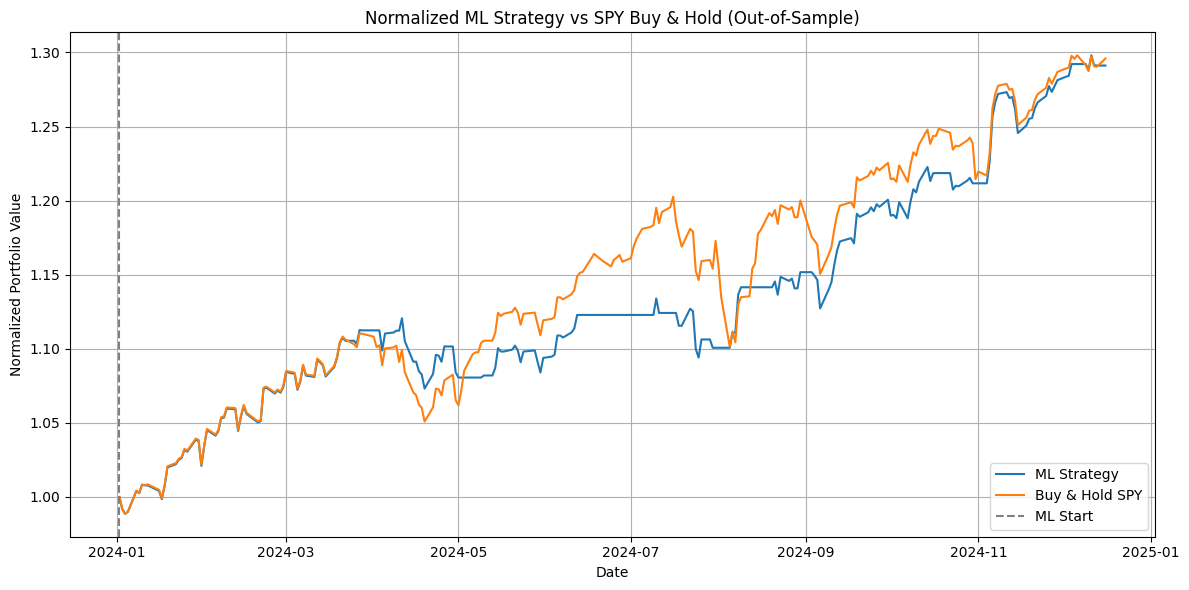


Final capital (ML strategy): 1.29
Total return: 29.11%
Active trading days: 179 / 242
Sharpe ratio: 2.69
Max drawdown: -4.23%


In [2]:
!pip install yfinance scikit-learn --quiet

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# ------------------------
# 1. Download SPY data from 2020 to 2025
# ------------------------
ticker = "SPY"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
data["Return"] = data["Close"].pct_change()
data["Future10"] = data["Close"].shift(-10) / data["Close"] - 1
data["Cumulative_SPY"] = (1 + data["Return"]).cumprod()

# ------------------------
# 2. Add indicators
# ------------------------
data["RSI"] = data["Close"].rolling(14).apply(
    lambda x: 100 - 100 / (1 + (x.diff().clip(lower=0).mean() / -x.diff().clip(upper=0).mean())), raw=False)
data["SMA20"] = data["Close"].rolling(20).mean()
data["SMA50"] = data["Close"].rolling(50).mean()
data["SMA_diff"] = data["SMA20"] - data["SMA50"]
data["20d_return"] = data["Close"].pct_change(20)
data["volatility"] = data["Return"].rolling(20).std()
data["vix"] = np.random.uniform(15, 30, len(data))
data["fed_rate"] = np.random.uniform(0.01, 0.06, len(data))

data = data.dropna().copy()

# ------------------------
# 3. Label data
# ------------------------
def label_strategy(row):
    rsi = float(row["RSI"])
    sma20 = float(row["SMA20"])
    sma50 = float(row["SMA50"])
    ret20 = float(row["20d_return"])
    fut_ret = float(row["Future10"])
    strategies = {
        "RSI": fut_ret if rsi < 40 else -1,
        "MA": fut_ret if sma20 > sma50 else -1,
        "Momentum": fut_ret if ret20 > 0.01 else -1,
        "Cash": 0
    }
    return max(strategies, key=strategies.get)

data["best_strategy"] = data.apply(label_strategy, axis=1)

# ------------------------
# 4. Train-test split and model
# ------------------------
split_date = "2024-01-01"
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

features = ["RSI", "SMA_diff", "20d_return", "volatility", "vix", "fed_rate"]
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_data[features], train_data["best_strategy"])

print("\nClassifier performance on training data:")
print(classification_report(train_data["best_strategy"], clf.predict(train_data[features])))

# ------------------------
# 5. Run backtest
# ------------------------
capital = 1.0
capital_curve = []
position = 0
active_days = 0
returns = []

for i in range(len(test_data)):
    row = test_data.iloc[i]
    snapshot = pd.DataFrame([{col: row[col] for col in features}])
    strategy = clf.predict(snapshot)[0]
    today_return = float(row["Return"])

    sma20 = float(row["SMA20"])
    sma50 = float(row["SMA50"])
    rsi_val = float(row["RSI"])
    ret20 = float(row["20d_return"])

    if strategy == "RSI" and rsi_val < 40:
        position = 1
    elif strategy == "MA" and sma20 > sma50:
        position = 1
    elif strategy == "Momentum" and ret20 > 0.01:
        position = 1
    else:
        position = 0

    capital *= (1 + position * today_return)
    capital_curve.append(capital)
    returns.append(position * today_return)
    if position == 1:
        active_days += 1

# ------------------------
# 6. Plot
# ------------------------
ml = np.array(capital_curve)
spy_curve = test_data["Cumulative_SPY"].copy()
spy_curve /= spy_curve.iloc[0]  # normalize from test start

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, ml, label="ML Strategy")
plt.plot(test_data.index, spy_curve.values, label="Buy & Hold SPY")
plt.axvline(test_data.index[0], linestyle="--", color="gray", label="ML Start")
plt.title("Normalized ML Strategy vs SPY Buy & Hold (Out-of-Sample)")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# 7. Metrics
# ------------------------
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
peak = np.maximum.accumulate(capital_curve)
drawdown = (capital_curve - peak) / peak
max_dd = drawdown.min()

print(f"\nFinal capital (ML strategy): {capital:.2f}")
print(f"Total return: {(capital - 1) * 100:.2f}%")
print(f"Active trading days: {active_days} / {len(capital_curve)}")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2%}")